## In this notebook  

This notebook provides an  example of using the pymsm package in a more complex setting which includes recurring ecents and time-varying covariates.  
We will also see how to load a saved model and run simualtions.  
For all this, we will use Israel COVID-19 hospitalization [public data](https://github.com/JonathanSomer/covid-19-multi-state-model/blob/master/data/data_for_paper.csv), as described in [Roimi et. al. 2021](https://academic.oup.com/jamia/article/28/6/1188/6105188).  

In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymsm.datasets import prep_covid_hosp_data
from pymsm.multi_state_competing_risks_model import MultiStateModel
from pymsm.statistics import (
    prob_visited_states,
    stats_total_time_at_states,
    get_path_frequencies,
    path_total_time_at_states
)
from pymsm.simulation import MultiStateSimulator

## Load data

In [1]:
from pymsm.plotting import state_diagram

state_diagram(
    """
    s1 : (1) Discharged \ Recovered
    s2: (2) Mild or Moderate
    s3: (3) Severe
    s4: (4) Deceased
    s1 --> s2
    s2 --> s1
    s2 --> s3
    s2 --> s4
    s3 --> s2
    s3 --> s4
"""
)


In [8]:
covid_dataset = prep_covid_hosp_data()

# Some definitions
covariate_cols = ["is_male", "age", "was_severe"]

states_labels_long = {
    0: "Censored",
    1: "Discharged\Recovered",
    2: "Mild or Moderate",
    3: "Severe",
    4: "Deceased",
}
states_labels = {0: "C", 1: "R", 2: "M", 3: "S", 4: "D"}
terminal_states = [4]


100%|██████████| 2675/2675 [00:05<00:00, 501.81it/s]


Let's look at one patients path

In [9]:
covid_dataset[567].print_path()

Sample id: 577
States: [2 3 4]
Transition times: [ 6 31]
Covariates:
is_male        1.0
age           72.5
was_severe     0.0
Name: 567, dtype: float64


For the example above, we see a man aged 72.5,  
who follows a path of "Mild or Moderate"->"Severe"->"Deceased"  
with transition times of 6 and 31 days.

## Path frequencies  

We can print out a summary for all different trajectories in the data

In [10]:
path_freqs = get_path_frequencies(covid_dataset, states_labels)
print(path_freqs)

M->R                               1906
M                                   202
M->S                                 76
S->D                                 74
M->S->D                              59
M->S->M->R                           46
M->D                                 44
M->R->M->R                           42
S                                    42
M->R->M                              36
M->S->M                              35
S->M->R                              28
S->M                                 27
M->S->M->S                            8
S->R                                  6
S->M->S                               5
S->M->S->M->R                         3
S->M->D                               3
M->S->M->S->M                         3
M->S->M->S->M->R                      3
M->R->M->R->M->R                      3
M->S->R                               3
S->M->S->D                            2
M->S->M->D                            2
M->R->M->S                            2


## Define time-varying covariates  

We can define a custom "update_covariates_function" such as below: 

In [11]:
def covid_update_covariates_function(
    covariates_entering_origin_state,
    origin_state=None,
    target_state=None,
    time_at_origin=None,
    abs_time_entry_to_target_state=None,
):
    covariates = covariates_entering_origin_state.copy()

    # update is_severe covariate
    if origin_state == 3:
        covariates['was_severe'] = 1

    # # update cum_hosp_tim covariate
    # if ((origin_state==2) & (origin_state==3)):
    #     covariates["cum_hosp_time"] += time_at_origin

    return covariates

## Fitting the Multistate model

In [12]:
multi_state_model = MultiStateModel(covid_dataset, terminal_states, covid_update_covariates_function, covariate_cols,)
multi_state_model.fit()

Fitting Model at State: 2
>>> Fitting Transition to State: 1, n events: 2135
>>> Fitting Transition to State: 3, n events: 275
>>> Fitting Transition to State: 4, n events: 52
Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 98
>>> Fitting Transition to State: 3, n events: 2


/home/hagair/.cache/pypoetry/virtualenvs/pymsm-3fT5GPF--py3.8/lib/python3.8/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column is_male have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'is_male'].var())
>>> print(df.loc[~events, 'is_male'].var())

A very low variance means that the column is_male completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/hagair/.cache/pypoetry/virtualenvs/pymsm-3fT5GPF--py3.8/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.537. This may imp

Fitting Model at State: 3
>>> Fitting Transition to State: 2, n events: 193
>>> Fitting Transition to State: 1, n events: 9
>>> Fitting Transition to State: 4, n events: 135


/home/hagair/.cache/pypoetry/virtualenvs/pymsm-3fT5GPF--py3.8/lib/python3.8/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column was_severe have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'was_severe'].var())
>>> print(df.loc[~events, 'was_severe'].var())

A very low variance means that the column was_severe completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/hagair/.cache/pypoetry/virtualenvs/pymsm-3fT5GPF--py3.8/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.262. 

Note that we get some warnings for some of the transitions. These should be handled or at least acknowledged when fitting a model.

## Single patient stats  
Let's take a look at how the model models transitions for a single patient - a female aged 75  
We'll run a Monte-Carlo simulation for 100 samples and present some path statistics

In [13]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe":0}),
    origin_state=2,
    current_time=0,
    n_random_samples=100,
    max_transitions=10,
    print_paths=False,
    n_jobs=-1
)

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Let's calculate the probability of being in any of the states and also obtain stats regarding time in each state

In [14]:
# Probability of visiting any of the states
for state, state_label in states_labels_long.items():
    if state == 0:
        continue
    print(
        f"Probabilty of ever being {state_label} = {prob_visited_states(mc_paths, states=[state])}"
    )


# Stats for times at states
dfs = []
for state, state_label in states_labels_long.items():
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths, states=[state]),
            index=[state_label],
        )
    )
pd.concat(dfs).round(3).T


Probabilty of ever being Discharged\Recovered = 0.15
Probabilty of ever being Mild or Moderate = 1.0
Probabilty of ever being Severe = 0.34
Probabilty of ever being Deceased = 1.0


,Discharged\Recovered,Mild or Moderate,Severe
time_in_state_mean,5.030,4.400,0.930
time_in_state_std,14.072,2.814,2.137
time_in_state_median,0.000,4.000,0.000
time_in_state_min,0.000,1.000,0.000
time_in_state_max,73.000,14.000,14.000
time_in_state_quantile_0.1,0.000,2.000,0.000
time_in_state_quantile_0.25,0.000,3.000,0.000
time_in_state_quantile_0.75,0.000,5.000,1.000
time_in_state_quantile_0.9,21.100,7.000,3.000


Print out the path frequences for the sampled paths

In [15]:
path_freqs = get_path_frequencies(mc_paths, states_labels)
path_freqs.head(10)

M->D          54
M->S->D       31
M->R->M->D    12
M->R->S->D     3
dtype: int64

A CDF for the total time in hospital

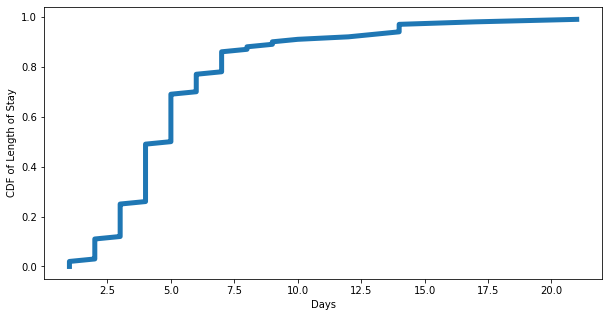

In [16]:
los = np.array([path_total_time_at_states(path, states = [2,3]) for path in mc_paths])

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(np.sort(los), np.linspace(0, 1, len(los), endpoint=False), lw=5)
# ax.set_xlim(0,20)
ax.set_ylabel('CDF of Length of Stay')
ax.set_xlabel('Days');

We can also look at Monte-Carlo simulations for the same patient, assuming we already know she has been in the Severe (3) state, for 2 days.

To do this, we simply need to set the *origin_state* to 3, set the *current_time* to 2, and update her covariates accordingly.

In [17]:
# Run MC for a sample single patient
mc_paths_severe = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe": 1}),
    origin_state=3,
    current_time=2,
    n_random_samples=100,
    max_transitions=10,
    print_paths=False,
    n_jobs=-1
)

100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Now we can calculate the probability of being in any of the states and obtain stats regarding time in each state.

We can compare these to the statistics we obtained above, when the patient started in a Mild (2) state.

In [18]:
# Probability of visiting any of the states
for state, state_label in states_labels_long.items():
    if state == 0:
        continue
    print(
        f"Probabilty of ever being {state_label} = {prob_visited_states(mc_paths_severe, states=[state])}"
    )


# Stats for times at states
dfs = []
for state, state_label in states_labels_long.items():
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths_severe, states=[state]),
            index=[state_label],
        )
    )
pd.concat(dfs).round(3).T

Probabilty of ever being Discharged\Recovered = 0.0
Probabilty of ever being Mild or Moderate = 0.05
Probabilty of ever being Severe = 1.0
Probabilty of ever being Deceased = 1.0


,Discharged\Recovered,Mild or Moderate,Severe
time_in_state_mean,0.0,0.120,7.680
time_in_state_std,0.0,0.682,10.151
time_in_state_median,0.0,0.000,5.000
time_in_state_min,0.0,0.000,0.000
time_in_state_max,0.0,6.000,83.000
time_in_state_quantile_0.1,0.0,0.000,0.000
time_in_state_quantile_0.25,0.0,0.000,2.000
time_in_state_quantile_0.75,0.0,0.000,9.250
time_in_state_quantile_0.9,0.0,0.000,15.300


## Saving the model and configuring a simulator  
We can save the model for later use, and configure a simulator to generate simulated paths

In [19]:
from pymsm.simulation import extract_competing_risks_models_list_from_msm

competing_risks_models_list = extract_competing_risks_models_list_from_msm(
    multi_state_model, verbose=True
)

# Configure the simulator
mssim = MultiStateSimulator(
    competing_risks_models_list,
    terminal_states=[5, 6],
    update_covariates_fn=covid_update_covariates_function,
    covariate_names=covariate_cols,
)


2 1 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f19e407ffa0>
2 3 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f198a5a92e0>
2 4 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f198a5c3280>
1 2 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f198a6877c0>
1 3 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f198a677c40>
3 2 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f198a5a7100>
3 1 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f198a5c3310>
3 4 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f198a5c38e0>


And now we can sample paths from this simulator  

In [20]:
# Run MC for a sample single patient
sim_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe": 0}),
    origin_state=3,
    current_time=2,
    n_random_samples=5,
    max_transitions=10,
    print_paths=True,
    n_jobs=-1
)

100%|██████████| 5/5 [00:00<00:00, 3283.98it/s]


States: [3, 2, 4]
Transition times: [10.000000695213053, 8.000048090191338]


States: [3, 4]
Transition times: [11.000062585991571]


States: [3, 4]
Transition times: [2.000094724857738]


States: [3, 4]
Transition times: [7.000089000534182]


States: [3, 4]
Transition times: [2.0000950607146937]


